In [3]:
import json
import random
import sys

import numpy as np

In [4]:
class QuadraticCost(object):
    
    @staticmethod
    def fn(a, y):
        return .5*np.linalg.norm(a-y)**2
    
    @staticmethod
    def delta(z, a, y):
        return (a-y) * sigmoid_prime(z)

In [5]:
class CrossEntropyCost(object):
    
    @staticmethod
    def fn(a, y):
        return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))
    
    @staticmethod
    def delta(z, a, y):
        return (a-y)

In [7]:
class Network(object):
    
    def __init__(self, sizes, cost=CrossEntropyCost):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.default_weight_initializer()
        self.cost = cost
        
    def default_weight_initializer(self):
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)/np.sqrt(x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]
    
    def large_weight_initializer(self):
        self.biases = [np.random.randn(y, 1) for y in self.sizes[1:]]
        self.weights = [np.random.randn(y, x)
                        for x, y in zip(self.sizes[:-1], self.sizes[1:])]
        
    def feedforward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = sigmoid(np.dot(w, a) + b)
        return a
    
    def SGD(self, training_data, epochs, mini_batch_size, eta, lmbda,
           evaluation_data=None,
           monitor_evaluation_cost=False,
           monitor_evaluation_accuracy=False,
           monitor_training_cost=False,
           monitor_training_accuracy=False):
        
        if evaluation_data: n_data = len(evaluation_data)
        n = len(training_data)
        evaluation_cost, evaluation_accuracy = [], []
        training_cost, training_accuracy = [], []
        for j in range(epochs):
            random.shuffle(training_data)
            mini_batches = [
                training_data[k:k+mini_batch_size]
                for k in range(0, n, mini_batch_size)]
            for mini_batch in mini_batches:
                self.update_mini_batch(mini_batch, eta, lmbda, len(training_data))
            print("Epoch", j, " training complete")
            
            if monitor_training_cost:
                cost = self.total_cost(training_data, lmbda)
                training_cost.append(cost)
                print("Cost on training data: {}".format(cost))
            if monitor_training_accuracy:
                accuracy = self.accuracy(training_data, convert=True)
                training_accuracy.append(accuracy)
                print("Accuracy on training data: {0} / {1}".format(accuracy, n))
            if monitor_evaluation_cost:
                cost = self.total_cost(evaluation_data, lmbda, convert=True)
                evaluation_cost.append(cost)
                print("Cost on evaluation data: {}".format(cost))
            if monitor_evaluation_accuracy:
                accuracy = self.accuracy(evaluation_data)
                evaluation_accuracy.append(accuracy)
                print("Accuracy on evaluation data: {} / {}".format(
                    self.accuracy(evaluation_data), n_data))
            print()
        return evaluation_cost, evaluation_accuracy, training_cost, training_accuracy

    def update_mini_batch(self, mini_batch, eta, lmbda, n):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [(1-eta*(lmbda/n))*w-(eta/len(mini_batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(mini_batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        # feedforward
        activation = x
        activations = [x] # list to store all the activations, layer by layer
        zs = [] # list to store all the z vectors, layer by layer
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        # backward pass
        delta = (self.cost).delta(zs[-1], activations[-1], y)
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].transpose())
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.dot(self.weights[-l+1].transpose(), delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l-1].transpose())
        return (nabla_b, nabla_w)
    
    def accuracy(self, data, convert=False):
        if convert:
            results = [(np.argmax(self.feedforward(x)), np.argmax(y))
                       for (x, y) in data]
        else:
            results = [(np.argmax(self.feedforward(x)), y)
                        for (x, y) in data]
        return sum(int(x == y) for (x, y) in results)
    
    def total_cost(self, data, lmbda, convert=False):
        cost = 0.0
        for x, y in data:
            a = self.feedforward(x)
            if convert: y = vectorized_result(y)
            cost += self.cost.fn(a, y)/len(data)
        cost += 0.5*(lmbda/len(data))*sum(
            np.linalg.norm(w)**2 for w in self.weights)
        return cost
    
    def save(self, filename):
        data = {"sizes": self.sizes,
                "weights": [w.tolist() for w in self.weights],
                "biases": [b.tolist() for b in self.biases],
                "cost": str(self.cost.__name__)}
        f = open(filename, "w")
        json.dump(data, f)
        f.close()    

In [8]:
def load(filename):
    f = open(filename, "r")
    data = json.load(f)
    f.close()
    cost = getattr(sys.modules[__name__], data["cost"])
    net = Network(data["sizes"], cost=cost)
    net.weights = [np.array(w) for w in data["weights"]]
    net.biases = [np.array(b) for b in data["biases"]]
    return net

def vectorized_result(j):
    e = np.zeros((10, 1))
    e[j] = 1.0
    return e

def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def sigmoid_prime(z):
    return sigmoid(z)*(1-sigmoid(z))

In [9]:
import mnist_loader
training_data, validation_data, test_data = mnist_loader.load_data_wrapper()
print(len(training_data))
print(len(validation_data))
print(len(test_data))

50000
10000
10000


In [17]:
net = Network([784, 30, 10], cost=CrossEntropyCost)
evaluation_cost, evaluation_accuracy, training_cost, training_accuracy = net.SGD(training_data[:1000], 30,1000,.5,lmbda=5,
                           evaluation_data=validation_data[:1000],
                           monitor_evaluation_accuracy=True,
                           monitor_evaluation_cost=True,
                           monitor_training_accuracy=True,
                           monitor_training_cost=True)

Epoch 0  training complete
Cost on training data: 3.4297163860251936
Accuracy on training data: 103 / 1000
Cost on evaluation data: 3.44504168243042
Accuracy on evaluation data: 108 / 1000

Epoch 1  training complete
Cost on training data: 3.360871370915752
Accuracy on training data: 231 / 1000
Cost on evaluation data: 3.3787591226461346
Accuracy on evaluation data: 194 / 1000

Epoch 2  training complete
Cost on training data: 3.329439148966627
Accuracy on training data: 210 / 1000
Cost on evaluation data: 3.347802698659716
Accuracy on evaluation data: 189 / 1000

Epoch 3  training complete
Cost on training data: 3.3082399308453194
Accuracy on training data: 212 / 1000
Cost on evaluation data: 3.327432632839228
Accuracy on evaluation data: 193 / 1000

Epoch 4  training complete
Cost on training data: 3.2898732875870684
Accuracy on training data: 219 / 1000
Cost on evaluation data: 3.3105691060173634
Accuracy on evaluation data: 198 / 1000

Epoch 5  training complete
Cost on training da

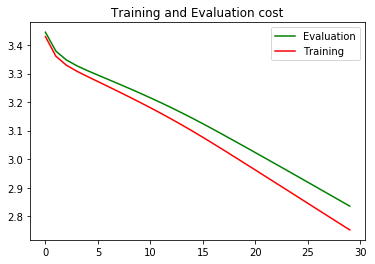

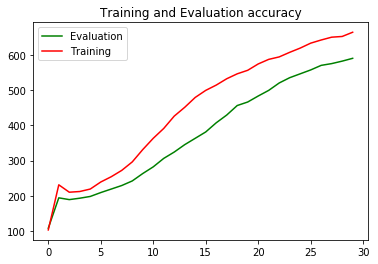

In [18]:
import matplotlib.pyplot as plt
plt.figure(1)
plt.plot(range(30), evaluation_cost, "g-", label='Evaluation')
plt.plot(range(30), training_cost, 'r-', label='Training')
plt.legend()
plt.title("Training and Evaluation cost")

plt.figure(2)
plt.plot(range(30), evaluation_accuracy, "g-", label='Evaluation')
plt.plot(range(30), training_accuracy, 'r-', label='Training')
plt.legend()
plt.title("Training and Evaluation accuracy")
plt.show()

In [19]:
net2 = Network([784, 30, 10], cost=CrossEntropyCost)
evaluation_cost2, evaluation_accuracy2, training_cost2, training_accuracy2 = net.SGD(training_data[:1000], 50, 1000, .5, lmbda=5,
                           evaluation_data=validation_data[:1000],
                           monitor_evaluation_accuracy=True,
                           monitor_evaluation_cost=True,
                           monitor_training_accuracy=True,
                           monitor_training_cost=True)

Epoch 0  training complete
Cost on training data: 2.7287929895424887
Accuracy on training data: 673 / 1000
Cost on evaluation data: 2.814464595122986
Accuracy on evaluation data: 594 / 1000

Epoch 1  training complete
Cost on training data: 2.705803355882783
Accuracy on training data: 675 / 1000
Cost on evaluation data: 2.793730574900026
Accuracy on evaluation data: 598 / 1000

Epoch 2  training complete
Cost on training data: 2.682995028331126
Accuracy on training data: 680 / 1000
Cost on evaluation data: 2.773139370836699
Accuracy on evaluation data: 602 / 1000

Epoch 3  training complete
Cost on training data: 2.6603982709228786
Accuracy on training data: 686 / 1000
Cost on evaluation data: 2.752721121656707
Accuracy on evaluation data: 606 / 1000

Epoch 4  training complete
Cost on training data: 2.6380406309386486
Accuracy on training data: 689 / 1000
Cost on evaluation data: 2.732503520269957
Accuracy on evaluation data: 613 / 1000

Epoch 5  training complete
Cost on training dat

Cost on evaluation data: 2.190110298748273
Accuracy on evaluation data: 731 / 1000

Epoch 43  training complete
Cost on training data: 2.0240375501099184
Accuracy on training data: 800 / 1000
Cost on evaluation data: 2.181068214803475
Accuracy on evaluation data: 734 / 1000

Epoch 44  training complete
Cost on training data: 2.0138811357528166
Accuracy on training data: 803 / 1000
Cost on evaluation data: 2.172212133520454
Accuracy on evaluation data: 736 / 1000

Epoch 45  training complete
Cost on training data: 2.003911377412615
Accuracy on training data: 805 / 1000
Cost on evaluation data: 2.1635364688805985
Accuracy on evaluation data: 736 / 1000

Epoch 46  training complete
Cost on training data: 1.9941227032576765
Accuracy on training data: 805 / 1000
Cost on evaluation data: 2.1550358416696778
Accuracy on evaluation data: 737 / 1000

Epoch 47  training complete
Cost on training data: 1.984509777838002
Accuracy on training data: 807 / 1000
Cost on evaluation data: 2.1467050785788

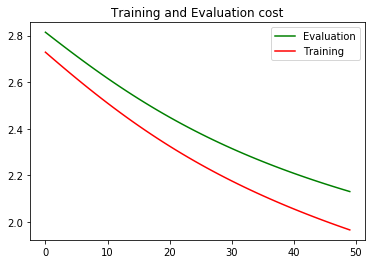

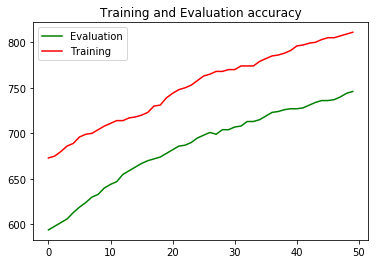

In [20]:
plt.figure(3)
plt.plot(range(50), evaluation_cost2, "g-", label='Evaluation')
plt.plot(range(50), training_cost2, 'r-', label='Training')
plt.legend()
plt.title("Training and Evaluation cost")

plt.figure(4)
plt.plot(range(50), evaluation_accuracy2, "g-", label='Evaluation')
plt.plot(range(50), training_accuracy2, 'r-', label='Training')
plt.legend()
plt.title("Training and Evaluation accuracy")
plt.show()

In [21]:
net3 = Network([784, 30, 10], cost=CrossEntropyCost)
evaluation_cost3, evaluation_accuracy3, training_cost3, training_accuracy3 = net.SGD(training_data[:1000], 50, 100, .5, lmbda=5,
                           evaluation_data=validation_data[:1000],
                           monitor_evaluation_accuracy=True,
                           monitor_evaluation_cost=True,
                           monitor_training_accuracy=True,
                           monitor_training_cost=True)

Epoch 0  training complete
Cost on training data: 1.8871334427956339
Accuracy on training data: 824 / 1000
Cost on evaluation data: 2.064965309600335
Accuracy on evaluation data: 768 / 1000

Epoch 1  training complete
Cost on training data: 1.813016036493398
Accuracy on training data: 828 / 1000
Cost on evaluation data: 2.0014868598909152
Accuracy on evaluation data: 766 / 1000

Epoch 2  training complete
Cost on training data: 1.7573168333052382
Accuracy on training data: 836 / 1000
Cost on evaluation data: 1.9607009892897413
Accuracy on evaluation data: 776 / 1000

Epoch 3  training complete
Cost on training data: 1.6990328934190424
Accuracy on training data: 863 / 1000
Cost on evaluation data: 1.9093119570056316
Accuracy on evaluation data: 807 / 1000

Epoch 4  training complete
Cost on training data: 1.651310253440946
Accuracy on training data: 869 / 1000
Cost on evaluation data: 1.8691658746189042
Accuracy on evaluation data: 808 / 1000

Epoch 5  training complete
Cost on training

Epoch 43  training complete
Cost on training data: 1.2891988006889685
Accuracy on training data: 944 / 1000
Cost on evaluation data: 1.6506418116067718
Accuracy on evaluation data: 860 / 1000

Epoch 44  training complete
Cost on training data: 1.2894001507396935
Accuracy on training data: 950 / 1000
Cost on evaluation data: 1.6650896959788541
Accuracy on evaluation data: 852 / 1000

Epoch 45  training complete
Cost on training data: 1.2851788262663544
Accuracy on training data: 948 / 1000
Cost on evaluation data: 1.654551068736299
Accuracy on evaluation data: 852 / 1000

Epoch 46  training complete
Cost on training data: 1.2834012369392853
Accuracy on training data: 951 / 1000
Cost on evaluation data: 1.6506788716078424
Accuracy on evaluation data: 850 / 1000

Epoch 47  training complete
Cost on training data: 1.2794843939087035
Accuracy on training data: 952 / 1000
Cost on evaluation data: 1.6547933611488297
Accuracy on evaluation data: 852 / 1000

Epoch 48  training complete
Cost on 

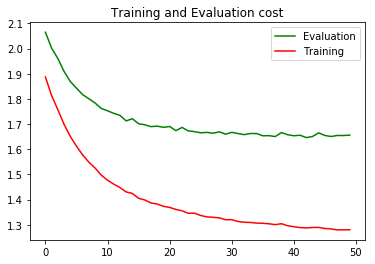

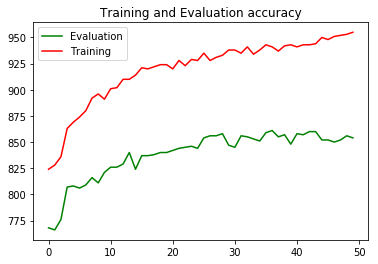

In [22]:
plt.figure(5)
plt.plot(range(50), evaluation_cost3, "g-", label='Evaluation')
plt.plot(range(50), training_cost3, 'r-', label='Training')
plt.legend()
plt.title("Training and Evaluation cost")

plt.figure(6)
plt.plot(range(50), evaluation_accuracy3, "g-", label='Evaluation')
plt.plot(range(50), training_accuracy3, 'r-', label='Training')
plt.legend()
plt.title("Training and Evaluation accuracy")
plt.show()

In [26]:
net2 = Network([784, 30, 10], cost=CrossEntropyCost)
evaluation_cost2, evaluation_accuracy2, training_cost2, training_accuracy2 = net.SGD(training_data[:1000], 300, 100, .5, lmbda=5,
                           evaluation_data=validation_data[:1000],
                           monitor_evaluation_accuracy=True,
                           monitor_evaluation_cost=True,
                           monitor_training_accuracy=True,
                           monitor_training_cost=True)

Epoch 0  training complete
Cost on training data: 1.2524545186291662
Accuracy on training data: 960 / 1000
Cost on evaluation data: 1.6510525687333575
Accuracy on evaluation data: 852 / 1000

Epoch 1  training complete
Cost on training data: 1.2516488060057223
Accuracy on training data: 961 / 1000
Cost on evaluation data: 1.6519010327973425
Accuracy on evaluation data: 859 / 1000

Epoch 2  training complete
Cost on training data: 1.2495705407175872
Accuracy on training data: 960 / 1000
Cost on evaluation data: 1.6464423586581876
Accuracy on evaluation data: 855 / 1000

Epoch 3  training complete
Cost on training data: 1.2517963701395347
Accuracy on training data: 962 / 1000
Cost on evaluation data: 1.6492061978765291
Accuracy on evaluation data: 857 / 1000

Epoch 4  training complete
Cost on training data: 1.2486816909918845
Accuracy on training data: 960 / 1000
Cost on evaluation data: 1.6470441743770674
Accuracy on evaluation data: 858 / 1000

Epoch 5  training complete
Cost on train

Epoch 43  training complete
Cost on training data: 1.2437441973849088
Accuracy on training data: 957 / 1000
Cost on evaluation data: 1.6495359735425246
Accuracy on evaluation data: 856 / 1000

Epoch 44  training complete
Cost on training data: 1.2400212251265625
Accuracy on training data: 961 / 1000
Cost on evaluation data: 1.6454269296965744
Accuracy on evaluation data: 860 / 1000

Epoch 45  training complete
Cost on training data: 1.2320261525590808
Accuracy on training data: 965 / 1000
Cost on evaluation data: 1.630462761323051
Accuracy on evaluation data: 868 / 1000

Epoch 46  training complete
Cost on training data: 1.2357301414010886
Accuracy on training data: 961 / 1000
Cost on evaluation data: 1.6336233401526905
Accuracy on evaluation data: 869 / 1000

Epoch 47  training complete
Cost on training data: 1.2370490036953672
Accuracy on training data: 963 / 1000
Cost on evaluation data: 1.652445445564445
Accuracy on evaluation data: 860 / 1000

Epoch 48  training complete
Cost on t

Accuracy on training data: 965 / 1000
Cost on evaluation data: 1.636246584313306
Accuracy on evaluation data: 861 / 1000

Epoch 87  training complete
Cost on training data: 1.2220139645560382
Accuracy on training data: 966 / 1000
Cost on evaluation data: 1.6311125226906422
Accuracy on evaluation data: 862 / 1000

Epoch 88  training complete
Cost on training data: 1.2253920031161891
Accuracy on training data: 965 / 1000
Cost on evaluation data: 1.624030127220953
Accuracy on evaluation data: 868 / 1000

Epoch 89  training complete
Cost on training data: 1.2212041441361814
Accuracy on training data: 967 / 1000
Cost on evaluation data: 1.6256187420434665
Accuracy on evaluation data: 868 / 1000

Epoch 90  training complete
Cost on training data: 1.2204320087590266
Accuracy on training data: 967 / 1000
Cost on evaluation data: 1.6256175533769914
Accuracy on evaluation data: 866 / 1000

Epoch 91  training complete
Cost on training data: 1.2214647728127095
Accuracy on training data: 965 / 1000

Epoch 129  training complete
Cost on training data: 1.2162316369967936
Accuracy on training data: 965 / 1000
Cost on evaluation data: 1.628853348909845
Accuracy on evaluation data: 863 / 1000

Epoch 130  training complete
Cost on training data: 1.2149273812411279
Accuracy on training data: 968 / 1000
Cost on evaluation data: 1.625519291438696
Accuracy on evaluation data: 862 / 1000

Epoch 131  training complete
Cost on training data: 1.214167339852556
Accuracy on training data: 970 / 1000
Cost on evaluation data: 1.6247272280690501
Accuracy on evaluation data: 869 / 1000

Epoch 132  training complete
Cost on training data: 1.2162052820416427
Accuracy on training data: 967 / 1000
Cost on evaluation data: 1.627386756136158
Accuracy on evaluation data: 865 / 1000

Epoch 133  training complete
Cost on training data: 1.2143548259789916
Accuracy on training data: 970 / 1000
Cost on evaluation data: 1.6248124778147917
Accuracy on evaluation data: 864 / 1000

Epoch 134  training complete
Cost 

Cost on evaluation data: 1.6259281948052227
Accuracy on evaluation data: 864 / 1000

Epoch 172  training complete
Cost on training data: 1.2121933945946066
Accuracy on training data: 967 / 1000
Cost on evaluation data: 1.6250247407143519
Accuracy on evaluation data: 858 / 1000

Epoch 173  training complete
Cost on training data: 1.2070646502091016
Accuracy on training data: 969 / 1000
Cost on evaluation data: 1.6182919952031387
Accuracy on evaluation data: 867 / 1000

Epoch 174  training complete
Cost on training data: 1.208010956053915
Accuracy on training data: 965 / 1000
Cost on evaluation data: 1.617938276128075
Accuracy on evaluation data: 864 / 1000

Epoch 175  training complete
Cost on training data: 1.209560856416793
Accuracy on training data: 967 / 1000
Cost on evaluation data: 1.6194496910119938
Accuracy on evaluation data: 867 / 1000

Epoch 176  training complete
Cost on training data: 1.2113876146048286
Accuracy on training data: 965 / 1000
Cost on evaluation data: 1.619745

Accuracy on training data: 967 / 1000
Cost on evaluation data: 1.616382509215526
Accuracy on evaluation data: 862 / 1000

Epoch 215  training complete
Cost on training data: 1.2062669786289488
Accuracy on training data: 967 / 1000
Cost on evaluation data: 1.617371668127701
Accuracy on evaluation data: 867 / 1000

Epoch 216  training complete
Cost on training data: 1.2080094286570113
Accuracy on training data: 967 / 1000
Cost on evaluation data: 1.62162277876575
Accuracy on evaluation data: 869 / 1000

Epoch 217  training complete
Cost on training data: 1.2045939296174795
Accuracy on training data: 967 / 1000
Cost on evaluation data: 1.615685860873132
Accuracy on evaluation data: 865 / 1000

Epoch 218  training complete
Cost on training data: 1.2054922840607571
Accuracy on training data: 967 / 1000
Cost on evaluation data: 1.618281414278428
Accuracy on evaluation data: 866 / 1000

Epoch 219  training complete
Cost on training data: 1.206300957483302
Accuracy on training data: 967 / 1000

Epoch 257  training complete
Cost on training data: 1.2028263327389717
Accuracy on training data: 968 / 1000
Cost on evaluation data: 1.6158316774613941
Accuracy on evaluation data: 863 / 1000

Epoch 258  training complete
Cost on training data: 1.2039548940964102
Accuracy on training data: 968 / 1000
Cost on evaluation data: 1.6232288560230095
Accuracy on evaluation data: 861 / 1000

Epoch 259  training complete
Cost on training data: 1.1996279166697792
Accuracy on training data: 969 / 1000
Cost on evaluation data: 1.6134683959247698
Accuracy on evaluation data: 866 / 1000

Epoch 260  training complete
Cost on training data: 1.2018534336231248
Accuracy on training data: 967 / 1000
Cost on evaluation data: 1.609965168189691
Accuracy on evaluation data: 863 / 1000

Epoch 261  training complete
Cost on training data: 1.2097241944901929
Accuracy on training data: 963 / 1000
Cost on evaluation data: 1.6249667270665809
Accuracy on evaluation data: 862 / 1000

Epoch 262  training complete
Co

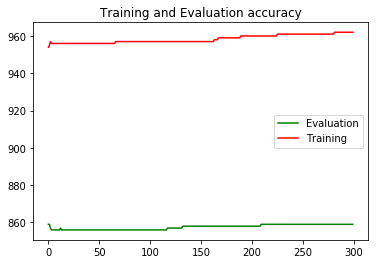

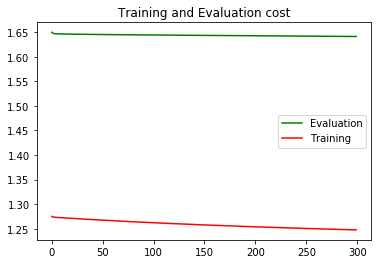

In [25]:
plt.figure(7)
plt.plot(range(300), evaluation_cost2, "g-", label='Evaluation')
plt.plot(range(300), training_cost2, 'r-', label='Training')
plt.legend()
plt.title("Training and Evaluation cost")

plt.figure(8)
plt.plot(range(300), evaluation_accuracy2, "g-", label='Evaluation')
plt.plot(range(300), training_accuracy2, 'r-', label='Training')
plt.legend()
plt.title("Training and Evaluation accuracy")
plt.show()